In [51]:
import torch 
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST



In [52]:
mnist = MNIST(root = 'Trainig_data/',
             train = True,
             download = True, 
             transform = Compose([ToTensor(), Normalize(mean=(0.5), std = (0.5,))]))

In [53]:
# Device Configuring for better performance
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [54]:

import matplotlib.pyplot as plt
img, label = mnist[0]

In [55]:
def denorm(x):
    out = (x+1) / 2
    return out.clamp(0, 1)

Label:  5


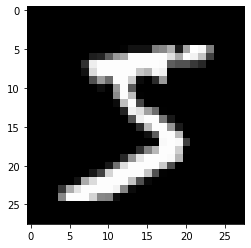

In [56]:
%matplotlib inline
i = denorm(img)
plt.imshow(i[0], cmap = 'gray')
print('Label: ', label)

In [57]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle = True)

batch size is some thing that is we are taking batches of 100 each so total baches will be 70000/100 i.e 700

50th batch
torch.Size([1, 28, 28])
tensor([2, 7, 1, 4, 9, 4, 1, 5, 5, 7, 6, 9, 1, 0, 9, 6, 8, 4, 8, 1, 1, 5, 2, 5,
        7, 8, 6, 2, 1, 9, 7, 1, 1, 6, 2, 9, 4, 5, 8, 3, 9, 0, 9, 6, 3, 7, 9, 6,
        5, 0, 9, 6, 0, 9, 0, 9, 3, 5, 9, 7, 2, 1, 1, 2, 7, 4, 7, 5, 1, 5, 6, 5,
        1, 6, 7, 7, 1, 6, 4, 8, 3, 9, 0, 4, 6, 2, 9, 6, 4, 8, 9, 6, 1, 5, 5, 9,
        4, 5, 8, 5])


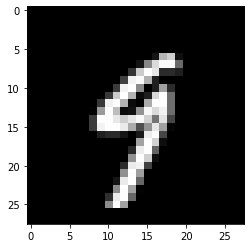

In [58]:
for img_batch, label_batch in data_loader:
    print('50th batch')
    print(img_batch[50].shape)
    plt.imshow(img_batch[50][0], cmap = 'gray')
    print( label_batch )
    break

In [59]:
img_size = 784
hidden_size = 512

In [60]:
import torch.nn as nn


D = nn.Sequential(
    nn.Linear(img_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [61]:
D.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=512, out_features=512, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=512, out_features=1, bias=True)
  (5): Sigmoid()
)

In [62]:
latent_size = 64

In [64]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, img_size),
    nn.Tanh())
  

In [65]:
G.to(device)

Sequential(
  (0): Linear(in_features=64, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=784, bias=True)
  (5): Tanh()
)

In [66]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(),lr = 0.0002)
g_optimizer = torch.optim.Adam(G.parameters(),lr = 0.0002)

In [67]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    
    

In [68]:
def train_discriminator(img):
    # Created the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
    
    #loss for real images
    outputs = D(img)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs
    
    #loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_scores = outputs
    
    #combine losses
    d_loss = d_loss_real + d_loss_fake
    
    #Reset Gradients
    reset_grad()
    
    # Compute gradients
    d_loss.backward()
    
    #Adjust the parameters using backprop
    d_optimizer.step()
    
    return d_loss, real_score, fake_scores

In [69]:
x = 15
for fake_images in range(x):
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    D(fake_images)
    print(denorm(fake_images))

tensor([[0.6225, 0.6176, 0.4744,  ..., 0.4944, 0.4931, 0.5172],
        [0.6012, 0.5453, 0.5079,  ..., 0.4321, 0.4717, 0.5039],
        [0.5452, 0.5422, 0.4717,  ..., 0.4547, 0.4915, 0.5502],
        ...,
        [0.5930, 0.6172, 0.5031,  ..., 0.4404, 0.4884, 0.4364],
        [0.6373, 0.6494, 0.5449,  ..., 0.4398, 0.4598, 0.4884],
        [0.6124, 0.5860, 0.5284,  ..., 0.4616, 0.4938, 0.4616]],
       device='cuda:0', grad_fn=<ClampBackward>)
tensor([[0.5313, 0.5708, 0.5025,  ..., 0.4815, 0.4162, 0.4752],
        [0.6009, 0.6341, 0.4991,  ..., 0.4262, 0.5259, 0.5389],
        [0.5920, 0.5236, 0.5119,  ..., 0.4502, 0.4595, 0.4747],
        ...,
        [0.5771, 0.5998, 0.4989,  ..., 0.4709, 0.3873, 0.4849],
        [0.5750, 0.5933, 0.5102,  ..., 0.4206, 0.4255, 0.5048],
        [0.5947, 0.5826, 0.5236,  ..., 0.4416, 0.4730, 0.5105]],
       device='cuda:0', grad_fn=<ClampBackward>)
tensor([[0.6048, 0.5767, 0.5512,  ..., 0.4855, 0.5082, 0.4844],
        [0.5661, 0.5554, 0.5302,  ..., 0.4

In [70]:
def train_generator():
    # Generate fake images and calculation loss
    z = torch.randn(batch_size, latent_size). to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)
    
    
    #Backprop and optimizer
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images
    

In [71]:
import os 
sample_dir = 'samples/'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

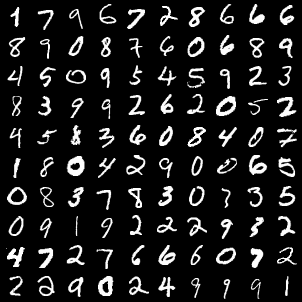

In [72]:
from IPython.display import Image
from torchvision.utils import save_image

for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), 
                os.path.join(sample_dir, 'real_images.png'), 
                nrow = 10)
    
Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


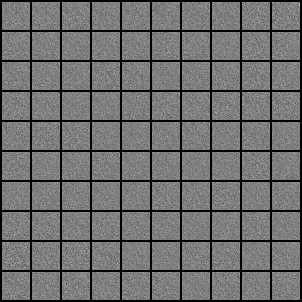

In [73]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [74]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0333, g_loss: 5.2762, D(x): 0.99, D(G(z)): 0.02
Epoch [0/300], Step [400/600], d_loss: 0.2117, g_loss: 7.8179, D(x): 0.92, D(G(z)): 0.07
Epoch [0/300], Step [600/600], d_loss: 0.0689, g_loss: 6.0977, D(x): 0.96, D(G(z)): 0.03
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0792, g_loss: 6.3542, D(x): 0.98, D(G(z)): 0.05
Epoch [1/300], Step [400/600], d_loss: 0.6642, g_loss: 6.1339, D(x): 0.80, D(G(z)): 0.12
Epoch [1/300], Step [600/600], d_loss: 0.4776, g_loss: 3.3664, D(x): 0.89, D(G(z)): 0.20
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.7176, g_loss: 3.1700, D(x): 0.89, D(G(z)): 0.38
Epoch [2/300], Step [400/600], d_loss: 0.8964, g_loss: 2.4340, D(x): 0.74, D(G(z)): 0.23
Epoch [2/300], Step [600/600], d_loss: 0.6191, g_loss: 2.5502, D(x): 0.79, D(G(z)): 0.20
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.5839, g_loss: 2.4831, D(x): 0.83, D(G(z)): 0.19
Epoch [3/300], Step [400/6

Epoch [27/300], Step [600/600], d_loss: 0.4623, g_loss: 4.6647, D(x): 0.88, D(G(z)): 0.14
Saving fake_images-0028.png
Epoch [28/300], Step [200/600], d_loss: 0.5421, g_loss: 2.8314, D(x): 0.91, D(G(z)): 0.23
Epoch [28/300], Step [400/600], d_loss: 0.3795, g_loss: 3.1535, D(x): 0.88, D(G(z)): 0.14
Epoch [28/300], Step [600/600], d_loss: 0.3241, g_loss: 3.5884, D(x): 0.89, D(G(z)): 0.12
Saving fake_images-0029.png
Epoch [29/300], Step [200/600], d_loss: 0.4321, g_loss: 2.9537, D(x): 0.88, D(G(z)): 0.19
Epoch [29/300], Step [400/600], d_loss: 0.4150, g_loss: 4.0710, D(x): 0.87, D(G(z)): 0.11
Epoch [29/300], Step [600/600], d_loss: 0.4701, g_loss: 3.9947, D(x): 0.85, D(G(z)): 0.09
Saving fake_images-0030.png
Epoch [30/300], Step [200/600], d_loss: 0.4101, g_loss: 3.5312, D(x): 0.84, D(G(z)): 0.10
Epoch [30/300], Step [400/600], d_loss: 0.3936, g_loss: 2.6170, D(x): 0.86, D(G(z)): 0.12
Epoch [30/300], Step [600/600], d_loss: 0.4006, g_loss: 3.3188, D(x): 0.90, D(G(z)): 0.17
Saving fake_imag

Epoch [55/300], Step [400/600], d_loss: 0.5859, g_loss: 1.7260, D(x): 0.89, D(G(z)): 0.30
Epoch [55/300], Step [600/600], d_loss: 0.7455, g_loss: 1.9483, D(x): 0.88, D(G(z)): 0.35
Saving fake_images-0056.png
Epoch [56/300], Step [200/600], d_loss: 0.4893, g_loss: 2.3693, D(x): 0.80, D(G(z)): 0.09
Epoch [56/300], Step [400/600], d_loss: 0.5387, g_loss: 1.7261, D(x): 0.85, D(G(z)): 0.23
Epoch [56/300], Step [600/600], d_loss: 0.6711, g_loss: 2.0201, D(x): 0.76, D(G(z)): 0.18
Saving fake_images-0057.png
Epoch [57/300], Step [200/600], d_loss: 0.6530, g_loss: 2.8632, D(x): 0.81, D(G(z)): 0.21
Epoch [57/300], Step [400/600], d_loss: 0.7023, g_loss: 3.0581, D(x): 0.82, D(G(z)): 0.25
Epoch [57/300], Step [600/600], d_loss: 0.5521, g_loss: 2.0132, D(x): 0.87, D(G(z)): 0.25
Saving fake_images-0058.png
Epoch [58/300], Step [200/600], d_loss: 0.6819, g_loss: 2.3537, D(x): 0.77, D(G(z)): 0.22
Epoch [58/300], Step [400/600], d_loss: 0.7837, g_loss: 1.8571, D(x): 0.86, D(G(z)): 0.36
Epoch [58/300], 

Epoch [83/300], Step [200/600], d_loss: 0.9188, g_loss: 1.3306, D(x): 0.76, D(G(z)): 0.32
Epoch [83/300], Step [400/600], d_loss: 0.7865, g_loss: 1.7488, D(x): 0.72, D(G(z)): 0.25
Epoch [83/300], Step [600/600], d_loss: 0.7672, g_loss: 2.4499, D(x): 0.76, D(G(z)): 0.26
Saving fake_images-0084.png
Epoch [84/300], Step [200/600], d_loss: 0.7694, g_loss: 2.4533, D(x): 0.66, D(G(z)): 0.13
Epoch [84/300], Step [400/600], d_loss: 0.6515, g_loss: 1.5709, D(x): 0.81, D(G(z)): 0.26
Epoch [84/300], Step [600/600], d_loss: 0.6626, g_loss: 2.3820, D(x): 0.74, D(G(z)): 0.20
Saving fake_images-0085.png
Epoch [85/300], Step [200/600], d_loss: 0.8763, g_loss: 1.8952, D(x): 0.82, D(G(z)): 0.36
Epoch [85/300], Step [400/600], d_loss: 0.9319, g_loss: 2.1228, D(x): 0.62, D(G(z)): 0.15
Epoch [85/300], Step [600/600], d_loss: 0.8677, g_loss: 2.1483, D(x): 0.68, D(G(z)): 0.23
Saving fake_images-0086.png
Epoch [86/300], Step [200/600], d_loss: 0.7030, g_loss: 2.2848, D(x): 0.75, D(G(z)): 0.22
Epoch [86/300], 

Epoch [110/300], Step [600/600], d_loss: 0.9992, g_loss: 1.4323, D(x): 0.61, D(G(z)): 0.25
Saving fake_images-0111.png
Epoch [111/300], Step [200/600], d_loss: 0.9883, g_loss: 1.7746, D(x): 0.73, D(G(z)): 0.36
Epoch [111/300], Step [400/600], d_loss: 1.1139, g_loss: 1.5088, D(x): 0.68, D(G(z)): 0.38
Epoch [111/300], Step [600/600], d_loss: 1.0375, g_loss: 1.8515, D(x): 0.64, D(G(z)): 0.28
Saving fake_images-0112.png
Epoch [112/300], Step [200/600], d_loss: 0.9019, g_loss: 1.4806, D(x): 0.67, D(G(z)): 0.24
Epoch [112/300], Step [400/600], d_loss: 0.8077, g_loss: 1.7351, D(x): 0.70, D(G(z)): 0.22
Epoch [112/300], Step [600/600], d_loss: 0.8119, g_loss: 1.3011, D(x): 0.74, D(G(z)): 0.30
Saving fake_images-0113.png
Epoch [113/300], Step [200/600], d_loss: 1.0690, g_loss: 1.4550, D(x): 0.71, D(G(z)): 0.39
Epoch [113/300], Step [400/600], d_loss: 0.9077, g_loss: 1.4988, D(x): 0.70, D(G(z)): 0.30
Epoch [113/300], Step [600/600], d_loss: 1.0871, g_loss: 1.7481, D(x): 0.66, D(G(z)): 0.34
Saving

Epoch [138/300], Step [200/600], d_loss: 0.8718, g_loss: 1.5393, D(x): 0.71, D(G(z)): 0.31
Epoch [138/300], Step [400/600], d_loss: 1.0556, g_loss: 1.4066, D(x): 0.61, D(G(z)): 0.31
Epoch [138/300], Step [600/600], d_loss: 0.8245, g_loss: 1.5005, D(x): 0.73, D(G(z)): 0.30
Saving fake_images-0139.png
Epoch [139/300], Step [200/600], d_loss: 0.8208, g_loss: 1.6113, D(x): 0.68, D(G(z)): 0.23
Epoch [139/300], Step [400/600], d_loss: 0.7581, g_loss: 1.8696, D(x): 0.70, D(G(z)): 0.24
Epoch [139/300], Step [600/600], d_loss: 0.6704, g_loss: 1.9675, D(x): 0.77, D(G(z)): 0.25
Saving fake_images-0140.png
Epoch [140/300], Step [200/600], d_loss: 1.1016, g_loss: 1.7165, D(x): 0.61, D(G(z)): 0.30
Epoch [140/300], Step [400/600], d_loss: 0.9223, g_loss: 1.1832, D(x): 0.73, D(G(z)): 0.36
Epoch [140/300], Step [600/600], d_loss: 1.0733, g_loss: 1.4119, D(x): 0.65, D(G(z)): 0.34
Saving fake_images-0141.png
Epoch [141/300], Step [200/600], d_loss: 0.8262, g_loss: 1.4720, D(x): 0.79, D(G(z)): 0.35
Epoch 

Epoch [165/300], Step [400/600], d_loss: 1.0395, g_loss: 1.6805, D(x): 0.64, D(G(z)): 0.26
Epoch [165/300], Step [600/600], d_loss: 0.9378, g_loss: 1.5016, D(x): 0.66, D(G(z)): 0.28
Saving fake_images-0166.png
Epoch [166/300], Step [200/600], d_loss: 1.0184, g_loss: 1.6129, D(x): 0.64, D(G(z)): 0.29
Epoch [166/300], Step [400/600], d_loss: 1.0018, g_loss: 1.2882, D(x): 0.63, D(G(z)): 0.28
Epoch [166/300], Step [600/600], d_loss: 0.9930, g_loss: 1.4302, D(x): 0.77, D(G(z)): 0.42
Saving fake_images-0167.png
Epoch [167/300], Step [200/600], d_loss: 0.9612, g_loss: 1.6346, D(x): 0.69, D(G(z)): 0.32
Epoch [167/300], Step [400/600], d_loss: 0.8935, g_loss: 1.6573, D(x): 0.72, D(G(z)): 0.31
Epoch [167/300], Step [600/600], d_loss: 1.0503, g_loss: 1.0709, D(x): 0.70, D(G(z)): 0.39
Saving fake_images-0168.png
Epoch [168/300], Step [200/600], d_loss: 0.9102, g_loss: 1.6394, D(x): 0.73, D(G(z)): 0.34
Epoch [168/300], Step [400/600], d_loss: 1.0820, g_loss: 1.8751, D(x): 0.69, D(G(z)): 0.36
Epoch 

Epoch [192/300], Step [600/600], d_loss: 0.8946, g_loss: 1.7075, D(x): 0.73, D(G(z)): 0.35
Saving fake_images-0193.png
Epoch [193/300], Step [200/600], d_loss: 1.0003, g_loss: 1.9570, D(x): 0.74, D(G(z)): 0.40
Epoch [193/300], Step [400/600], d_loss: 0.9198, g_loss: 1.4165, D(x): 0.81, D(G(z)): 0.40
Epoch [193/300], Step [600/600], d_loss: 1.0164, g_loss: 1.3900, D(x): 0.68, D(G(z)): 0.35
Saving fake_images-0194.png
Epoch [194/300], Step [200/600], d_loss: 0.8687, g_loss: 1.3970, D(x): 0.71, D(G(z)): 0.31
Epoch [194/300], Step [400/600], d_loss: 0.9576, g_loss: 1.6818, D(x): 0.70, D(G(z)): 0.33
Epoch [194/300], Step [600/600], d_loss: 0.8358, g_loss: 1.4379, D(x): 0.74, D(G(z)): 0.30
Saving fake_images-0195.png
Epoch [195/300], Step [200/600], d_loss: 0.8748, g_loss: 1.4187, D(x): 0.67, D(G(z)): 0.28
Epoch [195/300], Step [400/600], d_loss: 0.9932, g_loss: 1.1830, D(x): 0.67, D(G(z)): 0.32
Epoch [195/300], Step [600/600], d_loss: 0.8405, g_loss: 1.4715, D(x): 0.68, D(G(z)): 0.26
Saving

Epoch [220/300], Step [200/600], d_loss: 0.9480, g_loss: 1.6638, D(x): 0.73, D(G(z)): 0.36
Epoch [220/300], Step [400/600], d_loss: 0.9624, g_loss: 1.5190, D(x): 0.63, D(G(z)): 0.28
Epoch [220/300], Step [600/600], d_loss: 0.9543, g_loss: 1.3147, D(x): 0.75, D(G(z)): 0.39
Saving fake_images-0221.png
Epoch [221/300], Step [200/600], d_loss: 0.9602, g_loss: 1.9200, D(x): 0.60, D(G(z)): 0.21
Epoch [221/300], Step [400/600], d_loss: 0.9811, g_loss: 1.6241, D(x): 0.68, D(G(z)): 0.34
Epoch [221/300], Step [600/600], d_loss: 0.7083, g_loss: 1.4861, D(x): 0.74, D(G(z)): 0.25
Saving fake_images-0222.png
Epoch [222/300], Step [200/600], d_loss: 0.8338, g_loss: 1.4870, D(x): 0.70, D(G(z)): 0.26
Epoch [222/300], Step [400/600], d_loss: 0.9725, g_loss: 1.2904, D(x): 0.70, D(G(z)): 0.34
Epoch [222/300], Step [600/600], d_loss: 1.0108, g_loss: 2.0004, D(x): 0.66, D(G(z)): 0.29
Saving fake_images-0223.png
Epoch [223/300], Step [200/600], d_loss: 0.8853, g_loss: 1.3603, D(x): 0.71, D(G(z)): 0.32
Epoch 

Epoch [247/300], Step [400/600], d_loss: 1.0076, g_loss: 1.5625, D(x): 0.59, D(G(z)): 0.23
Epoch [247/300], Step [600/600], d_loss: 0.8840, g_loss: 1.6762, D(x): 0.79, D(G(z)): 0.38
Saving fake_images-0248.png
Epoch [248/300], Step [200/600], d_loss: 1.0019, g_loss: 1.4850, D(x): 0.64, D(G(z)): 0.26
Epoch [248/300], Step [400/600], d_loss: 0.9714, g_loss: 1.4566, D(x): 0.77, D(G(z)): 0.37
Epoch [248/300], Step [600/600], d_loss: 0.6962, g_loss: 1.5480, D(x): 0.79, D(G(z)): 0.26
Saving fake_images-0249.png
Epoch [249/300], Step [200/600], d_loss: 0.9574, g_loss: 1.5750, D(x): 0.75, D(G(z)): 0.34
Epoch [249/300], Step [400/600], d_loss: 0.8739, g_loss: 1.3861, D(x): 0.72, D(G(z)): 0.32
Epoch [249/300], Step [600/600], d_loss: 0.9140, g_loss: 1.4582, D(x): 0.67, D(G(z)): 0.29
Saving fake_images-0250.png
Epoch [250/300], Step [200/600], d_loss: 0.8903, g_loss: 1.4770, D(x): 0.70, D(G(z)): 0.29
Epoch [250/300], Step [400/600], d_loss: 0.8462, g_loss: 1.7443, D(x): 0.73, D(G(z)): 0.30
Epoch 

Epoch [274/300], Step [600/600], d_loss: 0.9119, g_loss: 1.8127, D(x): 0.68, D(G(z)): 0.27
Saving fake_images-0275.png
Epoch [275/300], Step [200/600], d_loss: 0.9087, g_loss: 1.8511, D(x): 0.71, D(G(z)): 0.29
Epoch [275/300], Step [400/600], d_loss: 0.7974, g_loss: 1.8109, D(x): 0.74, D(G(z)): 0.27
Epoch [275/300], Step [600/600], d_loss: 0.8642, g_loss: 1.8729, D(x): 0.66, D(G(z)): 0.24
Saving fake_images-0276.png
Epoch [276/300], Step [200/600], d_loss: 0.9105, g_loss: 1.7454, D(x): 0.68, D(G(z)): 0.28
Epoch [276/300], Step [400/600], d_loss: 0.7645, g_loss: 1.8027, D(x): 0.72, D(G(z)): 0.23
Epoch [276/300], Step [600/600], d_loss: 0.8657, g_loss: 1.8371, D(x): 0.66, D(G(z)): 0.24
Saving fake_images-0277.png
Epoch [277/300], Step [200/600], d_loss: 0.8704, g_loss: 1.4667, D(x): 0.68, D(G(z)): 0.30
Epoch [277/300], Step [400/600], d_loss: 0.9951, g_loss: 1.7808, D(x): 0.71, D(G(z)): 0.31
Epoch [277/300], Step [600/600], d_loss: 0.8703, g_loss: 1.8495, D(x): 0.76, D(G(z)): 0.35
Saving

In [75]:
import cv2
import os
from IPython.display import FileLink

video_avi = 'GAN_Output.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(video_avi,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('GAN_Output.avi')

C:\Users\ashis\OneDrive\Documents\Jupyter notebook\GAN_Output.avi

Text(0.5, 1.0, 'Losses')

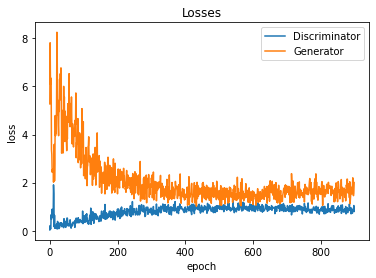

In [78]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

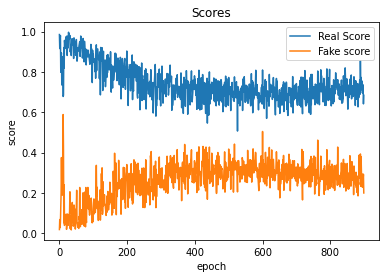

In [77]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

In [79]:
torch.save()


TypeError: save() missing 2 required positional arguments: 'obj' and 'f'